# Deep Supervised Graph Partitioning Model (DSGPM)

This Collab illustrates how to use pre-trained DSGPM model to predict CG mappings. DSGPM is a graph neural network graph partitioning model that can predict CG mappings of small to arbitrarily large molecules. 

## Citation


```
@Article{D0SC02458A,
author ="Li, Zhiheng and Wellawatte, Geemi P. and Chakraborty, Maghesree and Gandhi, Heta A. and Xu, Chenliang and White, Andrew D.",
title  ="Graph neural network based coarse-grained mapping prediction",
journal  ="Chem. Sci.",
year  ="2020",
pages  ="-",
publisher  ="The Royal Society of Chemistry",
doi  ="10.1039/D0SC02458A",
url  ="http://dx.doi.org/10.1039/D0SC02458A",
}

```




## Setup the conda environment and install dependencies

In [ ]:
#@title
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      %shell rm -rf /opt/conda
      %shell wget -q -P /tmp \
        https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
          && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
          && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
      pbar.update(10)

      PATH=%env PATH
      %env PATH=/opt/conda/bin:{PATH}
      %shell conda update -qy conda && conda install -qy -c conda-forge python=3.7
      pbar.update(15)
      #%shell conda install -qy -c pytorch cudatoolkit=10.2 
      %shell python -m pip install rdkit-pypi
      pbar.update(15)
      #%shell conda install -qy -c conda-forge rdkit
      %shell git clone https://github.com/rochesterxugroup/DSGPM.git
      pbar.update(10)
      %shell python -m pip install scikit-learn~=0.21.3 numpy~=1.19.1 scipy~=1.3.1  networkx~=2.4 tqdm~=4.47.0
      pbar.update(10)
      %shell conda install -qy cudatoolkit=10.1
      %shell python -m pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
      %shell pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html 
      pbar.update(40)
      
except subprocess.CalledProcessError:
  print(captured)
  raise

## Note:

In case you come across torch-geometry installation errors, it could be due to version mismatch errors. Relevant packages must be installed to resolve such version mismactches. We can do this by printing out the torch and cuda versions prior to instalation. 

For more details please visit PyTorch geometric [documentation!](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

# Using DSGPM to generate CG mappings

In this example let's use SMILES strings as inputs to DSGPM. Save one or many SMILES string in text file in your local computer and upload here. If you wish to generate mappings for arbitrarily large molecules, you can use PDB format. Please refer to our [documentation](https://github.com/rochesterxugroup/DSGPM#readme) on how to work with PDB inputs. 




In [ ]:
#@title Enter your SMILES string here. `bead_num` refers to the expected number of CG beads.
smiles = "CC1=CC=C(N=C1)C1=CC=C(C)C=N1" #@param {type:"string"}
bead_num = 5 #@param {type:"integer"}


with open('smiles.txt', 'w') as writefile:
    writefile.write(smiles)

# Set input and output paths
smiles_path = os.path.join(os.getcwd(),'smiles.txt')
out_path = os.getcwd()

# There are two steps associated with predicting a CG mapping using DSGPM



1.   Create a molecular graph using the input SMILES
2.   Partitioning the molecular graph to predict the mapping



In [ ]:
#@title
%shell python /content/DSGPM/generate_input_files/convert_to_json.py --smiles $smiles_path
%shell python /content/DSGPM/inference.py --pretrained_ckpt /content/DSGPM/model/DSGPM_trained.pth  --data_root /content/mol_graph/ --json_output_dir $out_path --num_cg_beads $bead_num --no_automorphism 

CC1=CC=C(N=C1)C1=CC=C(C)C=N1
conversion complete
100% 1/1 [00:00<00:00, 61.76it/s]


# Let's take a look at the output file now!

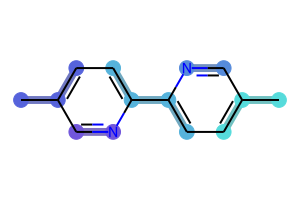

In [ ]:
#@title
import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem
import json
import seaborn as sns
import random
import re

outname = '/content/dsgpm/{}_cg_{}.json'.format(re.sub('[^A-Za-z0-9]+', '', smiles),bead_num)

cl1=list(sns.hls_palette(20, h=.5))
cl2=list(sns.hls_palette(20, s=.4,h=.5))

with open(outname,'r') as myfile:
  obj=json.load(myfile)
s=smiles
m = Chem.MolFromSmiles(s)
rdDepictor.Compute2DCoords(m)
aa=[]
ele=[]
atms={}
for nodes in obj['nodes']:
    j=int(nodes['cg'])
    k=int(nodes['id'])
    z=str(nodes['element'])
    ele.append(z)
    aa.append(k)
    value={k:cl1[j]}
    atms.update(value)
bl=[]
edges={}
a=(obj['nodes'])
for g in range(m.GetNumBonds()):
    begin=m.GetBonds()[g].GetBeginAtomIdx()
    end=m.GetBonds()[g].GetEndAtomIdx()
    if a[begin]['cg']==a[end]['cg']:
        bl.append(g)
        bond_value={g:cl2[a[begin]['cg']]}
        edges.update(bond_value)
drawer = rdMolDraw2D.MolDraw2DSVG(300,200)
drawer.DrawMolecule(m,highlightAtoms=aa,highlightBonds=bl,highlightAtomColors=atms,highlightBondColors=edges)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')

#================write to files============================
svg_path=os.path.join('/content/dsgpm/',outname.replace(".json", ".svg"))
svg_file= open(svg_path, "wt")
svg_file.write(svg)
svg_file.close()

from IPython.core.display import SVG
SVG(filename=svg_path)
 

In [ ]:
#@title A closer look at the output file saved in `dsgpm` folder

%shell cat $outname

{
    "cgnodes": [
        [
            0,
            1,
            2
        ],
        [
            3,
            4,
            7,
            8
        ],
        [
            5,
            6
        ],
        [
            9,
            10,
            11
        ],
        [
            12,
            13
        ]
    ],
    "edges": [
        {
            "bondtype": 1.0,
            "source": 0,
            "target": 1
        },
        {
            "bondtype": 2.0,
            "source": 1,
            "target": 2
        },
        {
            "bondtype": 1.0,
            "source": 2,
            "target": 3
        },
        {
            "bondtype": 2.0,
            "source": 3,
            "target": 4
        },
        {
            "bondtype": 1.0,
            "source": 4,
            "target": 5
        },
        {
            "bondtype": 2.0,
            "source": 5,
            "target": 6
        },
        {
            "bondtype": 1.0,
            "